# Deep Learning for Medical Imaging
## Project : Multimodal brain tumour segementation

This notebook contains the main code and explanations about the models. 

Note : if the computational power of the collab is not enough, the code will be transferred to a local computer for running the models.

In [0]:
!pip install SimpleITK

In [0]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.tensorboard
import torchvision
import torchvision.transforms
import os
import time
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
import sklearn.model_selection as model_selection
from tqdm import tqdm
import skimage

## 1) Data

Here is the code for downloading the dataset in order to train the models. The data comes from the medical segmentation decathlon : http://medicaldecathlon.com/ (then download Task01)

### 1.1) Downloading

Sometimes data doesn't download, maybe the simplest would be to import it from a stable github.

UPDATE : copy the Task01_BrainTumour.tar file to your Drive. Rename it to Task01_BrainTumour.tar (instead of Copy of Task01_BrainTumour.tar)

Then you can run the code, grant access of the notebook to your drive files and everything should work.

In [0]:
# doesn't work consistently
!pip install gdown
!gdown --id "1S8mgfnx8jwIFd3RZoJeMf6SrKrayLxj4"

Downloading...
From: https://drive.google.com/uc?id=1S8mgfnx8jwIFd3RZoJeMf6SrKrayLxj4
To: /content/Task01_BrainTumour.tar
7.61GB [02:39, 47.8MB/s]


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!ls /content/drive/My\ Drive

In [0]:
#!tar -xvf /content/drive/My\ Drive/Task01_BrainTumour.tar
!tar -xvf /content/Task01_BrainTumour.tar

Task01_BrainTumour/._dataset.json
Task01_BrainTumour/dataset.json
Task01_BrainTumour/._imagesTr
Task01_BrainTumour/imagesTr/
Task01_BrainTumour/imagesTr/BRATS_457.nii.gz
Task01_BrainTumour/imagesTr/BRATS_306.nii.gz
Task01_BrainTumour/imagesTr/BRATS_206.nii.gz
Task01_BrainTumour/imagesTr/BRATS_449.nii.gz
Task01_BrainTumour/imagesTr/BRATS_318.nii.gz
Task01_BrainTumour/imagesTr/BRATS_218.nii.gz
Task01_BrainTumour/imagesTr/BRATS_434.nii.gz
Task01_BrainTumour/imagesTr/BRATS_365.nii.gz
Task01_BrainTumour/imagesTr/BRATS_265.nii.gz
Task01_BrainTumour/imagesTr/BRATS_214.nii.gz
Task01_BrainTumour/imagesTr/BRATS_314.nii.gz
Task01_BrainTumour/imagesTr/BRATS_445.nii.gz
Task01_BrainTumour/imagesTr/BRATS_269.nii.gz
Task01_BrainTumour/imagesTr/BRATS_369.nii.gz
Task01_BrainTumour/imagesTr/BRATS_438.nii.gz
Task01_BrainTumour/imagesTr/BRATS_277.nii.gz
Task01_BrainTumour/imagesTr/BRATS_377.nii.gz
Task01_BrainTumour/imagesTr/BRATS_426.nii.gz
Task01_BrainTumour/imagesTr/BRATS_095.nii.gz
Task01_BrainTumour/i

### 1.2) Data analysis


Depending on how the tar archive is extracted, you need to point the right reference path to the Task01_BrainTumour folder.


In [0]:
#ref = '/content/drive/My Drive/'
ref = ''

In [0]:
#!ls /content/drive/My\ Drive/Task01_BrainTumour
!ls Task01_BrainTumour/

dataset.json  imagesTr	imagesTs  labelsTr


In [0]:
!ls Task01_BrainTumour/imagesTr/ | wc -l

484


So these are the 484 4D volumes for the training set. The directory Task01_BrainTumour/imagesTs/ should be the 266 volumes for the test set. 

We print below some sample files :

In [0]:
#!ls /content/drive/My\ Drive/Task01_BrainTumour/imagesTr/ | head
!ls Task01_BrainTumour/imagesTr/ | head

BRATS_001.nii.gz
BRATS_002.nii.gz
BRATS_003.nii.gz
BRATS_004.nii.gz
BRATS_005.nii.gz
BRATS_006.nii.gz
BRATS_007.nii.gz
BRATS_008.nii.gz
BRATS_009.nii.gz
BRATS_010.nii.gz


In [0]:
path_tr = ref+"Task01_BrainTumour/imagesTr/"
sample = "BRATS_001.nii.gz"

image = sitk.ReadImage(os.path.join(path_tr, sample))
keys = image.GetMetaDataKeys()
print('Metadata :')
for key in keys:
  print('{} : {}'.format(key, image.GetMetaData(key)))

Metadata :
ITK_FileNotes : 5.0.10
aux_file : none
bitpix : 32
cal_max : 0
cal_min : 0
datatype : 16
descrip : 5.0.10
dim[0] : 4
dim[1] : 240
dim[2] : 240
dim[3] : 155
dim[4] : 4
dim[5] : 1
dim[6] : 1
dim[7] : 1
dim_info :  
intent_code : 0
intent_name : 
intent_p1 : 0
intent_p2 : 0
intent_p3 : 0
pixdim[0] : 1
pixdim[1] : 1
pixdim[2] : 1
pixdim[3] : 1
pixdim[4] : 1
pixdim[5] : 0
pixdim[6] : 0
pixdim[7] : 0
qform_code : 1
qform_code_name : NIFTI_XFORM_SCANNER_ANAT
qoffset_x : 0
qoffset_y : 0
qoffset_z : 0
quatern_b : 0
quatern_c : 0
quatern_d : 0
scl_inter : 0
scl_slope : 1
sform_code : 1
sform_code_name : NIFTI_XFORM_SCANNER_ANAT
slice_code :  
slice_duration : 0
slice_end : 0
slice_start : 0
srow_x : 1 0 0 0
srow_y : 0 1 0 0
srow_z : 0 0 1 0
toffset : 0
vox_offset : 352
xyzt_units : 



The modalities appear in the 4th dimension : here dim[4] is 4, meaning we have the 4 modalities (FLAIR, T1, T1_gd and T2).

We need to produce segmentation labels of the different glioma sub-regions. As stated in the segmentation challenge BraTS 2017, the sub-regions considered for evaluation are: 
- The whole tumor (WT) : The WT describes the complete extent of the disease, as it entails the TC and the peritumoral edema (ED), which is typically depicted by hyper-intense signal in FLAIR. WT = ET + ED + NCR/NET. 
- The tumor core (TC): The TC entails the ET, as well as the necrotic (fluid-filled) and the non-enhancing (solid) parts of the tumor.The appearance of the necrotic (NCR) and the non-enhancing (NET) tumor core is typically hypo-intense in T1-Gd when compared to T1. TC = ET + NCR/NET 
- The enhancing tumor core (ET) : described by areas that show hyper-intensity in T1Gd when compared to T1, but also when compared to “healthy” white matter in T1Gd. 

The labels in the provided data are: 
- the GD-enhancing tumor (ET — label 4) (changed to be 3 for use), 
- the peritumoral edema (ED — label 2), 
- the necrotic and non-enhancing tumor (NCR/NET — label 1)
- and everything else (label 0) 

In [0]:
labels_tr = "Task01_BrainTumour/labelsTr"
sample = "BRATS_001.nii.gz"

image = sitk.ReadImage(os.path.join(labels_tr, sample))
keys = image.GetMetaDataKeys()
print('Metadata :')
for key in keys:
  print('{} : {}'.format(key, image.GetMetaData(key)))

Metadata :
ITK_FileNotes : 5.0.10
aux_file : none
bitpix : 8
cal_max : 0
cal_min : 0
datatype : 2
descrip : 5.0.10
dim[0] : 3
dim[1] : 240
dim[2] : 240
dim[3] : 155
dim[4] : 1
dim[5] : 1
dim[6] : 1
dim[7] : 1
dim_info :  
intent_code : 0
intent_name : 
intent_p1 : 0
intent_p2 : 0
intent_p3 : 0
pixdim[0] : 1
pixdim[1] : 1
pixdim[2] : 1
pixdim[3] : 1
pixdim[4] : 1
pixdim[5] : 0
pixdim[6] : 0
pixdim[7] : 0
qform_code : 1
qform_code_name : NIFTI_XFORM_SCANNER_ANAT
qoffset_x : 0
qoffset_y : 0
qoffset_z : 0
quatern_b : 0
quatern_c : 0
quatern_d : 0
scl_inter : 0
scl_slope : 1
sform_code : 1
sform_code_name : NIFTI_XFORM_SCANNER_ANAT
slice_code :  
slice_duration : 0
slice_end : 0
slice_start : 0
srow_x : 1 0 0 0
srow_y : 0 1 0 0
srow_z : 0 0 1 0
toffset : 0
vox_offset : 352
xyzt_units : 



In [0]:
np.unique(sitk.GetArrayFromImage(image))

array([0, 1, 2, 3], dtype=uint8)

## 2) Warm-up : Training a simple U-Net

The plan here is to look for the computation capabilities of the collab GPU. We reuse most of the code of the TP3, but adapted to 3D.




### 2.1) Training

In [0]:
def get_activation(activation_type):
    activation_type = activation_type.lower()
    if hasattr(nn, activation_type):
      return getattr(nn, activation_type)()
    else:
      return nn.ReLU()

def _make_nConv(in_channels, out_channels, nb_Conv, activation='ReLU'):
  layers = []
  layers.append(ConvBatchNorm(in_channels, out_channels, activation))

  for _ in range(nb_Conv-1):
      layers.append(ConvBatchNorm(out_channels, out_channels, activation))
  return nn.Sequential(*layers)

class ConvBatchNorm(nn.Module):
  """(convolution => [BN] => ReLU)"""
  
  def __init__(self, in_channels, out_channels, activation='ReLU'):
    super(ConvBatchNorm, self).__init__()
    self.conv = nn.Conv3d(in_channels, out_channels, 
                          kernel_size=3, padding=1)
    self.norm = nn.BatchNorm3d(out_channels)
    self.activation = get_activation(activation)
      
  def forward(self, x):
    out = self.conv(x)
    out = self.norm(out)
    return self.activation(out)

class DownBlock(nn.Module):
  """Downscaling with maxpool convolution"""

  def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
    super(DownBlock, self).__init__()
    self.maxpool = nn.MaxPool3d(2)
    self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)
        
  def forward(self, x):
    out = self.maxpool(x)
    return self.nConvs(out)  

class UpBlock(nn.Module):
  """Upscaling then conv"""

  def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
    super(UpBlock, self).__init__()
        
    self.up = nn.Upsample(scale_factor=2)
    self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

  def forward(self, x, skip_x):
    out = self.up(x)
    x = torch.cat([out, skip_x], dim=1) # dim 1 is the channel dimension
    return self.nConvs(x)

class UNet(nn.Module):
  def __init__(self, n_channels, n_classes):
    '''
    n_channels : number of channels of the input. 
                    By default 4, because we have 4 modalities
    n_labels : number of channels of the ouput.
                  By default 4 (3 labels + 1 for the background)
    '''
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.inc = ConvBatchNorm(n_channels, 64)
    self.down1 = DownBlock(64, 128, nb_Conv=2)
    self.down2 = DownBlock(128, 256, nb_Conv=2)
    self.down3 = DownBlock(256, 512, nb_Conv=2)
    self.down4 = DownBlock(512, 512, nb_Conv=2)
    self.up1 = UpBlock(1024, 256, nb_Conv=2)
    self.up2 = UpBlock(512, 128, nb_Conv=2)
    self.up3 = UpBlock(256, 64, nb_Conv=2)
    self.up4 = UpBlock(128, 64, nb_Conv=2)
    self.outc = nn.Conv3d(64, n_classes, kernel_size=3, stride=1, padding=1)
    self.last_activation = get_activation('Softmax')

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.last_activation(self.outc(x))
    return logits

In [0]:
path_tr = ref+"Task01_BrainTumour/imagesTr"
labels_tr = ref+"Task01_BrainTumour/labelsTr"

from os import listdir
from os.path import isfile, join

class TorchDataset(torch.utils.data.Dataset):

  def __init__(self, training=True, test=False, transform=None, seed = 10):
    super(TorchDataset, self).__init__()
    
    ##### 
    # split train/test files (from the original training files) use the same seed 
    #####
    files = [f for f in listdir(path_tr) if isfile(join(path_tr, f)) and not f.startswith('.')]
    files = sorted(files)
    np.random.seed(seed)
    np.random.shuffle(files)
    test_files = files[:121]
    train_files = files[121:]
    self.images_path = path_tr 
    self.labels_path = labels_tr
    
    if test or not training:
        self.files = test_files
    else:
        self.files = train_files 
    
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):

    patient = self.files[idx]

    irm, mask = self.load(patient)
    sample = (irm, mask)
        
    if self.transform:
      irm, mask = self.transform(sample)

    return (irm, mask, patient)

  def load(self, ID):

    patient_path = os.path.join(self.images_path, ID)
    irm = sitk.GetArrayFromImage(sitk.ReadImage(patient_path))

    mask_path = os.path.join(self.labels_path, ID)
    mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    mask[mask == 4] = 3
    label = 4
    mask = mask.astype(np.int16)
    mask = np.rollaxis(np.eye(label, dtype=np.uint8)[mask], -1, 0)
      
    return irm, mask

In [0]:
def dice_loss(input, target):
    smooth = 0.01
    target = target.float()
    input = input.float()
    input_flat = input.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection = (input_flat * target_flat).sum()
    return 1 - ((2. * intersection + smooth) /
                (input_flat.pow(2).sum() + target_flat.pow(2).sum() + smooth))

def mean_dice_loss(input, target):
  
  channels = list(range(target.shape[1]))
  loss = 0
  for channel in channels:
    dice = dice_loss(input[:, channel, ...],
                     target[:, channel, ...])
    loss += dice

  return loss / len(channels)

In [0]:
def to_var(x, device):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    x = x.to(device)
    return x

def to_numpy(x):
    if not (isinstance(x, np.ndarray) or x is None):
        if x.is_cuda: 
            x = x.data.cpu()
        x = x.numpy()
    return x

def save_checkpoint(state, save_path):

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    epoch = state['epoch']
    filename = save_path + '/' + \
        'model.{:02d}.pth.tar'.format(epoch)
    torch.save(state, filename)


def print_summary(epoch, i, nb_batch, loss, batch_time, 
                  average_loss, average_time, mode):
    '''
        mode = Train or Test
    '''
    summary = '[' + str(mode) + '] Epoch: [{0}][{1}/{2}]\t'.format(
        epoch, i, nb_batch)

    string = ''
    string += ('Dice Loss {:.4f} ').format(loss)
    string += ('(Average {:.4f}) \t').format(average_loss)
    string += ('Batch Time {:.4f} ').format(batch_time)
    string += ('(Average {:.4f}) \t').format(average_time)

    summary += string

    print(summary)

In [0]:
learning_rate = 1e-4
image_size = (128, 128, 80)
n_modality = 4
n_labels = 4
epochs = 1
batch_size = 1
print_frequency = 50
save_frequency = 10
save_model = True
tumor_percentage = 0.5
main_path = ref+'/warm_up/'
save_path = ref+'/warm_up/save/'
loss_function = 'dice_loss'
session_name = 'Test_session' + '_' + time.strftime('%m.%d %Hh%M')
model_path = save_path + 'models/' + session_name + '/'
tensorboard_folder = save_path + 'tensorboard_logs/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
# Reducing size is necessary to fit in the memory

def zoom(sample):
  irm, mask = sample
  irm_out = np.zeros((4, 80, 128, 128))
  for k in range(4):
    irm_out[k] = skimage.transform.resize(irm[k], (80, 128, 128))
  mask_out = np.zeros((4, 80, 128, 128))
  for k in range(4):
    mask_out[k] = np.round(skimage.transform.resize(mask[k].astype(float), (80, 128, 128)))
  return (irm_out, mask_out)

data_tr = TorchDataset(transform=zoom)
train_loader = torch.utils.data.DataLoader(data_tr, 
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

def train_model(model, loader, criterion, optimizer, fre=10):

  t0 = time.time()
  T = 0.
  total_loss = 0.

  for i, sample in enumerate(loader,1):
    (irms, masks, patients) = sample
    irms = to_var(irms.float(), device)
    masks = to_var(masks.float(), device)
    pred_masks = model(irms)
    dice_loss = criterion(pred_masks, masks)
    optimizer.zero_grad()
    dice_loss.backward()
    optimizer.step()
    batch_time = time.time() - t0
    T += batch_size*batch_time
    total_loss += batch_size*dice_loss
    average_loss = total_loss / (i * batch_size)
    average_time = T / (i * batch_size)

    t0 = time.time()
    
    if i % fre == 0:
        print_summary(epoch + 1, i, len(loader), dice_loss, batch_time,
                      average_loss, average_time, "Train")
        
  return dice_loss

def validate_model(model, loader, criterion):
  t0 = time.time()
  T = 0.
  total_loss = 0.

  for i, sample in enumerate(loader, 1):
      (irms, masks, patients) = sample
      irms = to_var(irms.float(), device)
      masks = to_var(masks.float(), device)
      pred_masks = model(irms)
      dice_loss = criterion(pred_masks, masks)

      batch_time = time.time() - t0
      T += batch_size * batch_time
      total_loss += batch_size * dice_loss
      average_loss = total_loss / (i * batch_size)
      average_time = T / (i * batch_size)

      t0 = time.time()
  print_summary(epoch + 1, i, len(loader), dice_loss, batch_time,
                average_loss, average_time,  "Validation")
  return average_loss

In [0]:
model = UNet(n_channels=n_modality, n_classes=n_labels)
model.to(device)
criterion = mean_dice_loss 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs): 
    print('\nEpoch [{}/{}] '.format(epoch+1, epochs))
    print(session_name)

    # train for one epoch
    model.train()
    print('Training')
    train_model(model, train_loader, criterion, optimizer)

    if save_model and epoch % save_frequency == 0:
        save_checkpoint({'epoch': epoch,
                        'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict()}, model_path)


Epoch [1/1] 
Test_session_03.28 18h25
Training
[Train] Epoch: [1][50/363]	Dice Loss 0.3536 (Average 0.5743) 	Batch Time 3.5149 (Average 3.5715) 	
[Train] Epoch: [1][100/363]	Dice Loss 0.3198 (Average 0.5152) 	Batch Time 3.5722 (Average 3.5667) 	
[Train] Epoch: [1][150/363]	Dice Loss 0.3127 (Average 0.4744) 	Batch Time 3.4969 (Average 3.5638) 	
[Train] Epoch: [1][200/363]	Dice Loss 0.2651 (Average 0.4479) 	Batch Time 3.5178 (Average 3.5526) 	
[Train] Epoch: [1][250/363]	Dice Loss 0.4530 (Average 0.4285) 	Batch Time 3.4690 (Average 3.5457) 	
[Train] Epoch: [1][300/363]	Dice Loss 0.3671 (Average 0.4114) 	Batch Time 3.4957 (Average 3.5415) 	
[Train] Epoch: [1][350/363]	Dice Loss 0.4855 (Average 0.3992) 	Batch Time 3.5111 (Average 3.5375) 	


('BRATS_141.nii.gz',)


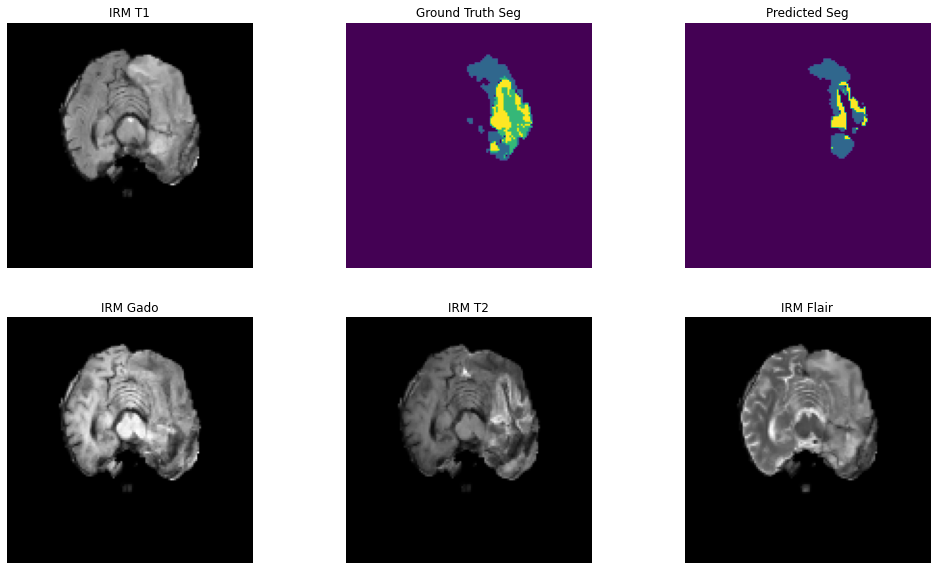

In [0]:
def plot(irms, masks=None, pred_masks=None):
    
    kwargs = {'cmap': 'gray'}

    z = np.random.randint(10, 70)
    k = 0
    while k < 1000 and np.sum(masks[1:, z, ...]) < 100:
      z = np.random.randint(10, 70)
      k += 1

    fig, ax = plt.subplots(2, 3, figsize=(15, 10),
                           gridspec_kw={'wspace': 0.15, 'hspace': 0.2,
                                              'top': 0.85, 'bottom': 0.1,
                                              'left': 0.05, 'right': 0.95})
        
    ax[0, 0].imshow(irms[0, z, :, :], **kwargs)
    
    if masks is not None:
        masks = np.argmax(masks, axis=0)
        ax[0, 1].imshow(masks[z,:,:], vmin=0, vmax=3)
        
    if pred_masks is not None:
        pred_masks = np.argmax(pred_masks, axis=0)
        ax[0, 2].imshow(pred_masks[z,:,:], vmin=0, vmax=3)

    for i in range(3):
        ax[1, i].imshow(irms[i+1, z, :, :], **kwargs)

    for i in range(2):
        for j in range(3):
            ax[i, j].grid(False)
            ax[i, j].axis('off')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    ax[0, 0].set_title('IRM T1')
    ax[1, 0].set_title('IRM Gado')
    ax[1, 1].set_title('IRM T2')
    ax[1, 2].set_title('IRM Flair')
    
    ax[0, 1].set_title('Ground Truth Seg')
    ax[0, 2].set_title('Predicted Seg')

    fig.canvas.draw()
    
    return fig

torch.cuda.empty_cache()
with torch.no_grad():
  model.eval()
  for i, sample in enumerate(train_loader, 1):
    (irm, mask, patient) = sample
    print(patient)
    break
  irm_ = to_var(irm.float(), device)
  mask_out_ = model(irm_)
  mask = to_numpy(mask)
  mask_out = to_numpy(mask_out_)
  plot(irm[0], masks=mask[0], pred_masks=mask_out[0])

### 2.2) Evaluation 
Evaluate for three parts:
- The whole tumor (WT) : includes all visible labels (1+2+3)
- The tumor core (TC): (1+3) 
- The enhancing tumor core (ET) : 3

In [0]:
## Dice coefficient 
def dice_score(mask1,mask2):
    # mask1 is true 
    # mask2 is predict 
    intersect = np.sum(mask1[mask2==1]==1)
    dice = intersect*2/(np.sum(mask1)+np.sum(mask2))
    return dice

def sensitivity(mask1,mask2):
    intersect = np.sum(mask1[mask2==1]==1)
    return intersect/np.sum(mask1)

def specificity(mask1,mask2):
    intersect = np.sum(mask1[mask2==0]==0)
    return intersect/np.sum(1-mask1)

## Hausdorff distance 
def haus_dis(mask_ref,mask):
    hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_distance_filter.Execute(mask_ref,mask)
    return hausdorff_distance_filter.GetHausdorffDistance()

def metrics(mask_, gt_):
    '''
    Taking to binary array of same shape as input
    This function compute the confusion matrix and use it to calculate 
    Dice metrics, Sensitivity and Specificity
    Input : mask_, gt_ numpy array of identic shape (only 1 and 0)
    Output : List of 3 scores
    '''
    lnot = np.logical_not
    land = np.logical_and

    true_positive = np.sum(land((mask_), (gt_)))
    false_positive = np.sum(land((mask_), lnot(gt_)))
    false_negative = np.sum(land(lnot(mask_), (gt_)))
    true_negative = np.sum(land(lnot(mask_), lnot(gt_)))

    M = np.array([[true_negative, false_negative],
                [false_positive, true_positive]]).astype(np.float64)
    metrics = {}
    metrics['Sensitivity'] = M[1, 1] / (M[0, 1] + M[1, 1]+1e-5)
    metrics['Specificity'] = M[0, 0] / (M[0, 0] + M[1, 0]+1e-5)
    metrics['Dice'] = 2 * M[1, 1] / (M[1, 1] * 2 + M[1, 0] + M[0, 1]+1e-5)
    # metrics may be NaN if denominator is zero! use np.nanmean() while
    # computing average to ignore NaNs.
    
    return [metrics['Dice'], metrics['Sensitivity'], metrics['Specificity']]

def calculate_regions(mask):
    wt = (mask==1) + (mask==3) + (mask==2)
    tc = (mask==1) + (mask==3)
    et = mask==3
    return wt,tc,et 

def evalAllmetric(mask_, gt_):
    '''
    This functions takes as input two numpy array with labels between
    0, 1, 2 and 4 and calculate the metrics as defined in BraTS data challenge
    mask_ and gt_ should be array of int
    '''
    ref_wt,ref_tc,ref_et = calculate_regions(mask_)
    wt,tc,et = calculate_regions(gt_)

    wt_metrics = metrics(ref_wt, wt)
    tc_metrics = metrics(ref_tc, tc)
    et_metrics = metrics(ref_et, et)

    #pd.DataFrame({'wt': wt_metrics, 'tc': tc_metrics, 'et': et_metrics},
                      #index=['Dice', 'Sensitivity', 'Specificity'])
    return wt_metrics+tc_metrics+et_metrics

def predict(loader, model, batch_size=1):

    metrics = []
    for i, sample in tqdm(enumerate(loader, 1)):
        # Take variable and put them to GPU
        (irm, mask, patient) = sample
        irm = to_var(irm.float(), device)
        mask = to_numpy(mask)
        pred_mask = to_numpy(model(irm))
        
        ref = np.argmax(mask,axis=1)
        mask_out = np.argmax(pred_mask,axis=1)
        
        metric = evalAllmetric(ref, mask_out)
        metrics.append(metric)
        
    return metrics

In [0]:
data_ts = TorchDataset(test=True,transform=zoom)
test_loader = torch.utils.data.DataLoader(data_ts, 
                                           batch_size=batch_size,
                                           drop_last=True)

torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    metrics = predict(test_loader, model, batch_size=1)

121it [07:28,  3.70s/it]


In [0]:
metrics_ar = np.stack(metrics,axis=0)
metrics_m = np.mean(metrics_ar,axis=0)
metrics_std = np.std(metrics_ar,axis=0)

mm = pd.DataFrame(metrics_m.reshape(3,-1),index=['wt','tc','et'])
mm.columns = ['Dice', 'Sensitivity', 'Specificity']
mm

,Dice,Sensitivity,Specificity
wt,0.417947,0.578169,0.992524
tc,0.352560,0.456136,0.993401
et,0.213522,0.451403,0.998226


Results are obviously bad here because we trained only for one epoch. The first issue is the time : it takes way too long for the training, and collab doesn't allow too long executions. So we trained models on local GPUs, and the results are shown in the report.

Still, for computational reasons, we switch to 2D segmentation in the experiments that follow. 

Notes :
- one could spare a lot of time and efficiency in the 3D model if PyTorch had a separable convolution layer (operation existing in Tensorflow, yet not implemented in PyTorch)
- another alternative would be using a 2.5D model, which would still use the advantages of having a 3D volume while not being to computationally expensive; however we don't really care about absolute performance as we want to compare methods for modalities fusion, thus a relative performance comparison is all we need.

##3) VAE network design



###3.1) Dataset and data augmentation


In [0]:
class Dataset_2D(torch.utils.data.Dataset):

  def __init__(self, mode="training", transform=None, modalities=[0,1,2,3], seed = 10, t=0.01, r=0.5):
    super(Dataset_2D, self).__init__()
    
    ##### 
    # split train/test files (from the original training files) use the same seed 
    #####
    files = [f for f in listdir(path_tr) if isfile(join(path_tr, f)) and not f.startswith('.')]
    files = sorted(files)
    np.random.seed(seed)
    np.random.shuffle(files)
    test_files = files[:121]
    val_files = files[121:181]
    train_files = files[181:]
    self.images_path = path_tr 
    self.labels_path = labels_tr
    self.modalities = np.array(modalities)
    
    if mode=="training":
        self.files = test_files
    elif mode=="validation":
        self.files = val_files 
    elif mode=="test":
        self.files = test_files
    
    self.IDs_list = get_IDs(self.files, threshold=t, background_ratio=r)
    
    self.transform = transform

  def __len__(self):
    return len(self.IDs_list)

  def __getitem__(self, idx):

    patient = self.IDs_list[idx]

    irm, mask = self.load(patient)
    sample = (irm, mask)
        
    if self.transform:
      irm, mask = self.transform(sample)

    return (irm[self.modalities, ...], mask, patient)

  def load(self, ID):

    (patient, z_slice) = ID
    patient_path = os.path.join(self.images_path, patient)
    irm = sitk.GetArrayFromImage(sitk.ReadImage(patient_path))
    irm = irm[:, z_slice,...]

    mask_path = os.path.join(self.labels_path, patient)
    mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    mask = mask[:, z_slice,...]
    mask[mask == 4] = 3
    label = 4
    mask = mask.astype(np.int16)
    mask = np.rollaxis(np.eye(label, dtype=np.uint8)[mask], -1, 0)
      
    return irm, mask

def get_IDs(files_list, threshold=0.01, background_ratio=0.5):
  IDs = []
  for file in files_list:
    mask_path = os.path.join(labels_tr, file)
    mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    mask[mask == 4] = 3
    label = 4
    mask = mask.astype(np.int16)
    mask = np.rollaxis(np.eye(label, dtype=np.uint8)[mask], -1, 0)
    Z = mask.shape[1]
    nb_slices = 0
    for z in range(Z):
      r = np.sum(mask[1:, z, ...])/(mask.shape[1]*mask.shape[2])
      if r > threshold:
        IDs.append((file, z))
        nb_slices += 1
    for z in range(Z):
      r = np.sum(mask[1:, z, ...])/(mask.shape[2]*mask.shape[3])
      if r < threshold:
        keep = np.random.random()
        if keep*(Z-nb_slices) < background_ratio*nb_slices:
          IDs.append((file, z))
  return IDs

In [0]:
# data normalization

def pre_normalize(img):
    # normalize one modality
    idx = np.where(img > 0)
    if len(idx[0]) == 0:
      return img
    non_zero = img[idx[0], idx[1]]
    img_m = np.mean(non_zero)
    img_std = np.std(non_zero)
    if img_std == 0.:
      return img - img_m
    img_new = (img - img_m) / img_std
    return img_new

# Data augmentation : scaling, croping, flipping

def flip_scale_crop_train(sample):
    irm, mask = sample
    irm_out = []
    mask_out = []
    
    # flip at 0.5 proba 
    d = np.random.randint(2)+1
    num = np.random.random() > 0.5
    if num:
        irm = np.flip(irm,axis=d)
        mask = np.flip(mask,axis=d)
    
    # scale 
    factor = np.random.random()/5. + 0.9
    for k in range(4):
        irm_out.append(skimage.transform.rescale(pre_normalize(irm[k]), factor))
    for k in range(4):
        mask_out.append(np.round(skimage.transform.rescale(mask[k].astype(float),factor)))
    irm_out_ = np.stack(irm_out,axis=0)
    mask_out_ = np.stack(mask_out,axis=0)
    
    # crop image 
    _, X, Y = irm_out_.shape
    r1 = np.random.randint(1, X//4)
    r2 = np.random.randint(1, X//4)
    r3 = np.random.randint(1, Y//4)
    r4 = np.random.randint(1, Y//4)
    irm_ = irm_out_[:,r1:-r2, r3:-r4]
    mask_ = mask_out_[:,r1:-r2, r3:-r4]   

    # resize to wanted (128 * 128)
    for k in range(4):
      irm_out[k] = skimage.transform.resize(irm_[k], (128, 128))
    for k in range(4):
      mask_out[k] = np.round(skimage.transform.resize(mask_[k].astype(float), (128, 128)))
    irm_out = np.stack(irm_out,axis=0)
    mask_out = np.stack(mask_out,axis=0)

    return (irm_out, mask_out)

def flip_scale_crop_test(sample):
    irm, mask = sample
    irm_out = []
    mask_out = []

    # crop
    irm_ = irm[:,20:220, 20:220]
    mask_ = mask[:,20:220, 20:220]   

    # resize to wanted (128 * 128)
    for k in range(4):
      irm_out.append(skimage.transform.resize(pre_normalize(irm_[k]), (128, 128)))
    for k in range(4):
      mask_out.append(np.round(skimage.transform.resize(mask_[k].astype(float), (128, 128))))
    irm_out = np.stack(irm_out,axis=0)
    mask_out = np.stack(mask_out,axis=0)
    
    return (irm_out, mask_out)

In [0]:
# create datasets

training = Dataset_2D(mode="training", transform=flip_scale_crop_train)
train_IDs = training.IDs_list

val = Dataset_2D(mode="validation", transform=flip_scale_crop_test)

test = Dataset_2D(mode="test", transform=flip_scale_crop_test)

We created the 2D dataset by keeping slices that had at least 1% tumour in it, plus roughly the same amount of slices with less than 1% tumour. This is balanced sampling : half of samples contain actual material of interest, the other half is here just for regularization (to avoid the bias induced by class imbalance).

We verify that the empirical 1% threshold lets us select enough slices :

In [0]:
print('Total number of training 2D samples : ', len(train_IDs))
dic = {}
for (a, b) in train_IDs:
  if not a in dic:
    dic[a] = []
  dic[a].append(b)
for key in dic:
  print(key, len(dic[key]))

Total number of training 2D samples :  10016
BRATS_152.nii.gz 128
BRATS_326.nii.gz 50
BRATS_436.nii.gz 60
BRATS_388.nii.gz 83
BRATS_312.nii.gz 57
BRATS_399.nii.gz 102
BRATS_140.nii.gz 122
BRATS_412.nii.gz 90
BRATS_483.nii.gz 59
BRATS_359.nii.gz 39
BRATS_331.nii.gz 95
BRATS_044.nii.gz 66
BRATS_164.nii.gz 92
BRATS_162.nii.gz 78
BRATS_270.nii.gz 87
BRATS_099.nii.gz 87
BRATS_120.nii.gz 50
BRATS_427.nii.gz 126
BRATS_103.nii.gz 76
BRATS_297.nii.gz 58
BRATS_147.nii.gz 86
BRATS_150.nii.gz 133
BRATS_220.nii.gz 80
BRATS_437.nii.gz 91
BRATS_048.nii.gz 117
BRATS_460.nii.gz 99
BRATS_101.nii.gz 74
BRATS_191.nii.gz 100
BRATS_330.nii.gz 27
BRATS_108.nii.gz 98
BRATS_413.nii.gz 48
BRATS_143.nii.gz 73
BRATS_213.nii.gz 114
BRATS_092.nii.gz 95
BRATS_454.nii.gz 57
BRATS_445.nii.gz 91
BRATS_355.nii.gz 36
BRATS_025.nii.gz 47
BRATS_471.nii.gz 109
BRATS_112.nii.gz 93
BRATS_117.nii.gz 120
BRATS_262.nii.gz 48
BRATS_115.nii.gz 78
BRATS_292.nii.gz 122
BRATS_082.nii.gz 88
BRATS_258.nii.gz 73
BRATS_301.nii.gz 58
BRAT

However for computational issues we might also need a smaller dataset with only tumours 

:

In [0]:
training_2 = Dataset_2D(mode="training", transform=flip_scale_crop_train, t=0.05, r=0.)
train_IDs = training_2.IDs_list
print('Total number of training 2D samples : ', len(train_IDs))

validation_2 = Dataset_2D(mode="validation", transform=flip_scale_crop_test, t=0.05, r=0.)

Total number of training 2D samples :  2908


###3.2) Model

Inspired from the paper : 3D MRI Brain Tumor Segmentation Using Autoencoder Regularization, Myronenko et al.

The model consists in a 2D U-net architecture, with an encoder and a decoder using skip connections. Its specificity is that it adds a second decoder branch, without skip connections, meant to reconstruct the original image. Basically we have a segmentation network and a variational autoencoder which share the encoder part. Plus the convolution blocks are actually ResNet blocks : an identity skip connection connects the input and the output of the block for a better backward pass.

In [0]:
from torch.distributions.normal import Normal
from torch.nn import Linear

def get_activation(activation_type):
    activation_type = activation_type.lower()
    if hasattr(nn, activation_type):
      return getattr(nn, activation_type)()
    else:
      return nn.ReLU()

class ConvBatchNorm2D(nn.Module):
  """(convolution => [BN] => ReLU)"""
  
  def __init__(self, in_channels, out_channels, activation='ReLU'):
    super(ConvBatchNorm2D, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, 
                          kernel_size=3, padding=1)
    self.norm = nn.BatchNorm2d(out_channels)
    self.activation = get_activation(activation)
      
  def forward(self, x):
    out = self.conv(x)
    out = self.norm(out)
    return self.activation(out)

class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, nb_Conv=2, activation="ReLU", skip=True):
    super(ResBlock, self).__init__()
    self.nb_Conv = nb_Conv
    self.skip = skip
    layers = [ConvBatchNorm2D(in_channels, out_channels, activation)]
    for k in range(nb_Conv-1):
      layers.append(ConvBatchNorm2D(out_channels, out_channels, activation))
    self.convs = nn.Sequential(*layers)

  def forward(self, x):
    y = self.convs(x)
    if self.skip:
      out = torch.cat([x, y], dim=1)
    else:
      out = y
    return out

class DownBlock2D(nn.Module):
  """Downscaling with maxpool convolution"""

  def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
    super(DownBlock2D, self).__init__()
    self.maxpool = nn.MaxPool2d(2)
    self.nConvs = ResBlock(in_channels, out_channels, nb_Conv, activation)
        
  def forward(self, x):
    out = self.maxpool(x)
    return self.nConvs(out)  

class UpBlock2D(nn.Module):
  """Upscaling then conv"""

  def __init__(self, in_channels, out_channels, nb_Conv, skip=True, activation='ReLU'):
    super(UpBlock2D, self).__init__()
        
    self.skip = skip
    self.up = nn.Upsample(scale_factor=2)
    self.nConvs = ResBlock(in_channels, out_channels, nb_Conv, activation, skip=False)

  def forward(self, x, skip_x):
    out = self.up(x)
    if self.skip:
      out = torch.cat([out, skip_x], dim=1) # dim 1 is the channel dimension
    return self.nConvs(out)

class Sample(nn.Module):
  def __init__(self, in_features, out_features):
    super(Sample, self).__init__()
    self.mean_linear = Linear(in_features, out_features)
    self.std_linear = Linear(in_features, out_features)

  def forward(self, x):
    mu = self.mean_linear(x)
    sigma = self.std_linear(x)
    distrib = Normal(mu, sigma)
    out = distrib.sample()
    return out, mu, sigma


class VAE_UNet(nn.Module):
  def __init__(self, n_channels, n_classes):
    '''
    n_channels : number of channels of the input. 
                    By default 4, because we have 4 modalities
    n_labels : number of channels of the ouput.
                  By default 4 (3 labels + 1 for the background)
    '''
    super(VAE_UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.inc = ResBlock(n_channels, 60, 2, 'ReLU')
    self.down1 = DownBlock2D(64, 64, nb_Conv=2)
    self.down2 = DownBlock2D(128, 128, nb_Conv=2)
    self.down3 = DownBlock2D(256, 256, nb_Conv=2)
    # Only 3 down because we want to keep spatial information for the VAE

    # Classical up for U-Net
    self.up1 = UpBlock2D(768, 128, nb_Conv=2)
    self.up2 = UpBlock2D(256, 64, nb_Conv=2)
    self.up3 = UpBlock2D(128, 64, nb_Conv=2)
    self.outc = nn.Conv2d(64, n_classes, kernel_size=3, stride=1, padding=1)
    self.last_activation = get_activation('Softmax')

    # VAE branch
    self.sample = Sample(512*16*16, 256)
    self.dense = Linear(256, 256*128)
    self.vae_up1 = UpBlock2D(128, 128, nb_Conv=2, skip=False)
    self.vae_up2 = UpBlock2D(128, 64, nb_Conv=2, skip=False)
    self.vae_up3 = UpBlock2D(64, 32, nb_Conv=2, skip=False)
    self.vae_out = nn.Conv2d(32, n_channels, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)

    # Segmentation
    x = self.up1(x4, x3)
    x = self.up2(x, x2)
    x = self.up3(x, x1)
    logits = self.last_activation(self.outc(x))

    # VAE
    y, mu, sigma = self.sample(torch.flatten(x4, 1))
    y1 = self.dense(y)
    y2 = torch.reshape(y1, (-1, 128, 16, 16))
    y3 = self.vae_up1(y2, x3)
    y4 = self.vae_up2(y3, x2)
    y5 = self.vae_up3(y4, x1)
    img_out = self.vae_out(y5)
    return logits, img_out, mu*mu, sigma*sigma

In [0]:
from torchsummary import summary

model = VAE_UNet(n_channels=n_modality, n_classes=n_labels)
model.cuda()
summary(model, (4,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 60, 128, 128]           2,220
       BatchNorm2d-2         [-1, 60, 128, 128]             120
              ReLU-3         [-1, 60, 128, 128]               0
   ConvBatchNorm2D-4         [-1, 60, 128, 128]               0
            Conv2d-5         [-1, 60, 128, 128]          32,460
       BatchNorm2d-6         [-1, 60, 128, 128]             120
              ReLU-7         [-1, 60, 128, 128]               0
   ConvBatchNorm2D-8         [-1, 60, 128, 128]               0
          ResBlock-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
  ConvBatchNorm2D-14           [-1, 64,

### 3.3) Testing model

In [0]:
from torch.nn.functional import mse_loss

def print_summary_vae(epoch, i, nb_batch, loss, batch_time, l2, kl,
                  average_loss, average_time, avg_l2, avg_kl, mode):
    '''
        mode = Train or Test
    '''
    summary = '[' + str(mode) + '] Epoch: [{0}][{1}/{2}]\t'.format(
        epoch, i, nb_batch)

    string = ''
    string += ('Dice Loss {:.4f} ').format(loss)
    string += ('(Average {:.4f}) \t').format(average_loss)
    string += ('Batch Time {:.4f} ').format(batch_time)
    string += ('(Average {:.4f}) \t').format(average_time)
    string += ('L2 Loss {:.4f} ').format(l2)
    string += ('(Average {:.4f}) \t').format(avg_l2)
    string += ('KL Loss {:.4f} ').format(kl)
    string += ('(Average {:.4f}) \t').format(avg_kl)

    summary += string

    print(summary)

def train_model_vae(model, loader, criterion_seg, optimizer, lambda_ = 0.1, fre=100, device=device):
    t0 = time.time()
    T = 0.
    total_loss = 0.
    l2_loss = 0.
    kl_loss = 0.

    for i, sample in enumerate(loader, 1):
        (irms, masks, patients) = sample

        irms = to_var(irms.float(), device)
        masks = to_var(masks.float(), device)
        pred_masks, img_out, mu2, sigma2 = model(irms)
        dice_loss = criterion_seg(pred_masks, masks)
        vae_l2_loss = mse_loss(img_out, irms)
        vae_kl_loss = torch.mean(mu2 + sigma2 - torch.log(sigma2) - 1.)
        loss = dice_loss + lambda_ * (vae_l2_loss + vae_kl_loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time = time.time() - t0
        T += batch_size * batch_time
        total_loss += batch_size * dice_loss
        average_loss = total_loss / (i * batch_size)
        average_time = T / (i * batch_size)

        l2_loss += batch_size * vae_l2_loss
        average_l2 = l2_loss / (i * batch_size)
        kl_loss += batch_size * vae_kl_loss
        average_kl  = kl_loss / (i *batch_size)

        t0 = time.time()
        
        if i % fre == 0:
            print_summary_vae(epoch + 1, i, len(loader), dice_loss, batch_time, vae_l2_loss, vae_kl_loss, 
                          average_loss, average_time, average_l2, average_kl, "Train")
    print_summary_vae(epoch + 1, i, len(loader), dice_loss, batch_time, vae_l2_loss, vae_kl_loss, 
                          average_loss, average_time, average_l2, average_kl, "Train")
    return average_loss

In [0]:
def validate_model_vae(model, loader, criterion):
    t0 = time.time()
    T = 0.
    total_loss = 0.
    l2_loss = 0.
    kl_loss = 0.

    for i, sample in enumerate(loader, 1):
        (irms, masks, patients) = sample
        irms = to_var(irms.float(), device)
        masks = to_var(masks.float(), device)
        pred_masks, img_out, mu2, sigma2 = model(irms)
        print(img_out.shape)
        dice_loss = criterion(pred_masks, masks)
        vae_l2_loss = mse_loss(img_out, irms)
        vae_kl_loss = torch.mean(mu2 + sigma2 - torch.log(sigma2) - 1.)

        batch_time = time.time() - t0
        T += batch_size * batch_time
        total_loss += batch_size * dice_loss
        average_loss = total_loss / (i * batch_size)
        average_time = T / (i * batch_size)

        l2_loss += batch_size * vae_l2_loss
        average_l2 = l2_loss / (i * batch_size)
        kl_loss += batch_size * vae_kl_loss
        average_kl  = kl_loss / (i *batch_size)

        t0 = time.time()

        if i % print_frequency == 0:
            print_summary_vae(epoch + 1, i, len(loader), dice_loss, batch_time, vae_l2_loss, vae_kl_loss, 
                          average_loss, average_time, average_l2, average_kl, "Validation")
    print_summary_vae(epoch + 1, i, len(loader), dice_loss, batch_time, vae_l2_loss, vae_kl_loss, 
                          average_loss, average_time, average_l2, average_kl, "Validation")
    return average_loss

In [0]:
def mean_dice_loss_2(input, target):
  
  channels = list(range(target.shape[1]))
  loss = 0
  for channel in channels[1:]:
    dice = dice_loss(input[:, channel, ...],
                     target[:, channel, ...])
    loss += dice

  return loss / (len(channels)-1)

In [0]:
learning_rate = 1e-4
image_size = (128, 128)

n_modality = 4
n_labels = 4

epochs = 3
batch_size = 64

print_frequency = 10
save_model = False

In [0]:
# train model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#if torch.cuda.is_available():
#    model.cuda()
criterion = mean_dice_loss_2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(training, 
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

train_losses = []
val_losses = []
#early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(epochs+1):
    print('\nEpoch [{}/{}] '.format(epoch + 1, epochs))
    #print(session_name)

    model.train()
    print('[Training]')
    tr_loss = train_model_vae(model, train_loader, mean_dice_loss_2, optimizer, lambda_=0.1, fre=print_frequency, device=device)
    train_losses.append(tr_loss)

    if save_model and epoch % save_frequency == 0:
        save_checkpoint({'epoch': epoch,
                         'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict()}, model_path)


Epoch [1/1] 
[Training]
[Train] Epoch: [1][10/156]	Dice Loss 0.7744 (Average 0.8364) 	Batch Time 40.6911 (Average 40.1406) 	L2 Loss 9.1819 (Average 9.5673) 	KL Loss 9.6947 (Average 13.1503) 	
[Train] Epoch: [1][20/156]	Dice Loss 0.8057 (Average 0.8302) 	Batch Time 40.5689 (Average 40.1439) 	L2 Loss 9.2299 (Average 9.0804) 	KL Loss 7.8769 (Average 10.7548) 	
[Train] Epoch: [1][30/156]	Dice Loss 0.8160 (Average 0.8261) 	Batch Time 40.2173 (Average 40.0768) 	L2 Loss 7.8142 (Average 8.7189) 	KL Loss 8.0183 (Average 9.9122) 	
[Train] Epoch: [1][40/156]	Dice Loss 0.8281 (Average 0.8219) 	Batch Time 39.3035 (Average 40.0138) 	L2 Loss 7.2444 (Average 123.3176) 	KL Loss 16.0489 (Average 14.3806) 	
[Train] Epoch: [1][50/156]	Dice Loss 0.8626 (Average 0.8222) 	Batch Time 39.6551 (Average 39.9800) 	L2 Loss 7.6942 (Average 111.8761) 	KL Loss 14.9892 (Average 15.5867) 	
[Train] Epoch: [1][60/156]	Dice Loss 0.7837 (Average 0.8149) 	Batch Time 39.0813 (Average 39.9193) 	L2 Loss 6.4718 (Average 94.411

IndexError: ignored

In [0]:
# validation for one epoch
val_loader = torch.utils.data.DataLoader(val, 
                                         batch_size=batch_size, shuffle=True,
                                         drop_last=True)
print('[Validation]')
with torch.no_grad():
    model.eval()
    val_loss = validate_model_vae(model, val_loader, criterion)
    val_losses.append(val_loss)

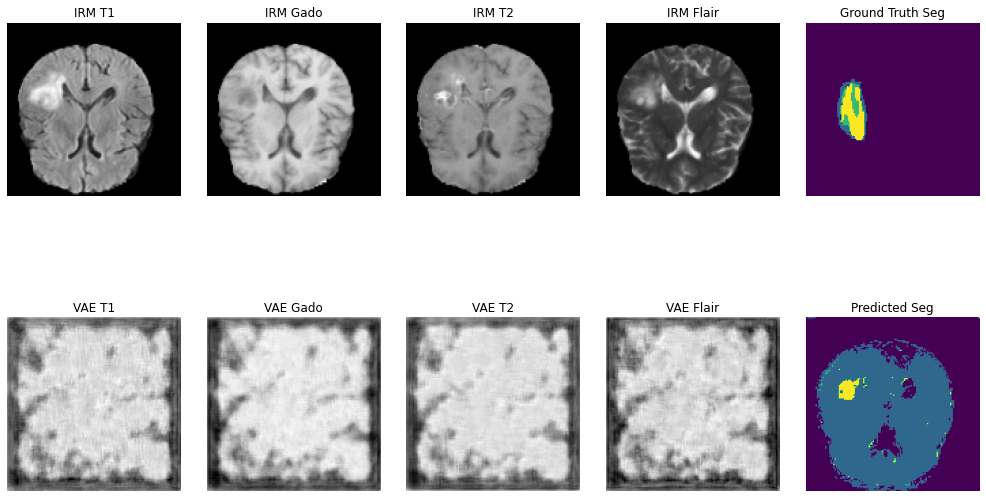

In [0]:
def plot_vae(irms, masks=None, pred_masks=None, reconstructed=None):
    
    kwargs = {'cmap': 'gray'}

    fig, ax = plt.subplots(2, 5, figsize=(15, 10),
                           gridspec_kw={'wspace': 0.15, 'hspace': 0.2,
                                              'top': 0.85, 'bottom': 0.1,
                                              'left': 0.05, 'right': 0.95})
        
    ax[0, 0].imshow(irms[0, :, :], **kwargs)
    ax[1, 0].imshow(reconstructed[0, ...], **kwargs)
    
    if masks is not None:
        masks = np.argmax(masks, axis=0)
        ax[0, 4].imshow(masks[:,:], vmin=0, vmax=3)
        
    if pred_masks is not None:
        pred_masks = np.argmax(pred_masks, axis=0)
        ax[1, 4].imshow(pred_masks[:,:], vmin=0, vmax=3)

    for i in range(3):
        ax[1, i+1].imshow(reconstructed[i+1, ...], **kwargs)
        ax[0, i+1].imshow(irms[i+1, :, :], **kwargs)

    for i in range(2):
        for j in range(5):
            ax[i, j].grid(False)
            ax[i, j].axis('off')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    ax[0, 0].set_title('IRM T1')
    ax[0, 1].set_title('IRM Gado')
    ax[0, 2].set_title('IRM T2')
    ax[0, 3].set_title('IRM Flair')

    ax[1, 0].set_title('VAE T1')
    ax[1, 1].set_title('VAE Gado')
    ax[1, 2].set_title('VAE T2')
    ax[1, 3].set_title('VAE Flair')
    
    ax[0, 4].set_title('Ground Truth Seg')
    ax[1, 4].set_title('Predicted Seg')

    fig.canvas.draw()
    
    return fig
train_loader = torch.utils.data.DataLoader(training, 
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

torch.cuda.empty_cache()
with torch.no_grad():
  model.train()
  for i, sample in enumerate(train_loader, 1):
    (irm, mask, patient) = sample
#    print(patient)
    if torch.sum(mask[0, 1:,...])>100:
      break
  irm_ = to_var(irm.float(), device)
  mask_out_,img_out_,_,_ = model(irm_)
  mask = to_numpy(mask)
  mask_out = to_numpy(mask_out_)
  img_out = to_numpy(img_out_)
  plot_vae(irm[0], masks=mask[0], pred_masks=mask_out[0], reconstructed=img_out[0])

## 4) Fusion experiments

Here we showcase three different models for modalities integration :
- a fusion on the input of the network, which is exactly what we did previously in 2.1) and 3.3)
- a fusion after training a model for each modality; this is akin to an ensemble method, but with different inputs
- a fusion of the features at the end of the encoder part

All these will have an impact on the performance of the network at the segmentation level.


### 4.1) Input fusion

We use a 2D U-net with ResNet-like skip connections in the convolution blocks, and output its results.

In [0]:
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels_):
    super(Encoder, self).__init__()
    self.in_channels = in_channels 
    self.out_channels = out_channels_ # list of channels out of each block
    out_channels = np.cumsum([in_channels]+out_channels_)[1:]
    self.inc = ResBlock(in_channels, out_channels_[0])
    self.down1 = DownBlock2D(out_channels[0], out_channels_[1], nb_Conv=2)
    self.down2 = DownBlock2D(out_channels[1], out_channels_[2], nb_Conv=2)
    self.down3 = DownBlock2D(out_channels[2], out_channels_[3], nb_Conv=2)
    self.down4 = DownBlock2D(out_channels[3], out_channels_[4], nb_Conv=2)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    return x1, x2, x3, x4, x5

class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels, n_classes):
    super(Decoder, self).__init__()
    self.in_channels = in_channels # must be a list of the nb of channels of inputs x1, ..., x5
    self.out_channels = out_channels #list of the nb of channels that each up conv must produce
    self.up1 = UpBlock2D(in_channels[-1] + in_channels[-2], out_channels[0], nb_Conv=2)
    self.up2 = UpBlock2D(out_channels[0] + in_channels[-3], out_channels[1], nb_Conv=2)
    self.up3 = UpBlock2D(out_channels[1] + in_channels[-4], out_channels[2], nb_Conv=2)
    self.up4 = UpBlock2D(out_channels[2] + in_channels[-5], out_channels[3], nb_Conv=2)
    self.outc = nn.Conv2d(out_channels[3], n_classes, kernel_size=3, stride=1, padding=1)
    self.last_activation = get_activation('Softmax')

  def forward(self, x1, x2, x3, x4, x5):
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.last_activation(self.outc(x))
    return logits

class UNet2D(nn.Module):
  def __init__(self, n_channels, n_classes, encoder_channels):
    '''
    n_channels : number of channels of the input. 
                    By default 4, because we have 4 modalities
    n_labels : number of channels of the ouput.
                  By default 4 (3 labels + 1 for the background)
    '''
    super(UNet2D, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.encoder = Encoder(n_channels, encoder_channels)
    out_channels = np.cumsum([n_channels]+encoder_channels)[1:]
    self.decoder = Decoder(out_channels, list(reversed(out_channels[:4])), n_classes)

  def forward(self, x):
    x1, x2, x3, x4, x5 = self.encoder(x)
    logits = self.decoder(x1, x2, x3, x4, x5)
    return logits

In [0]:
epochs = 3
batch_size = 64
print_frequency = 5

# train model
model_0 = UNet2D(4, 4, [28,32,64,128,256])
model_0.cuda()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#if torch.cuda.is_available():
#    model.cuda()
criterion = mean_dice_loss_2
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(training_2, 
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(validation_2, 
                                         batch_size=batch_size, shuffle=True,
                                         drop_last=True)

train_losses = []
val_losses = []
#early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(epochs+1):
    print('\nEpoch [{}/{}] '.format(epoch + 1, epochs))
    #print(session_name)

    model_0.train()
    print('[Training]')
    tr_loss = train_model(model_0, train_loader, mean_dice_loss_2, optimizer, fre=print_frequency)
    train_losses.append(tr_loss)

    if save_model and epoch % save_frequency == 0:
        save_checkpoint({'epoch': epoch,
                         'state_dict': model_0.state_dict(),
                         'optimizer': optimizer.state_dict()}, model_path)

    # validation for one epoch
    print('[Validation]')
    with torch.no_grad():
        model_0.eval()
        val_loss = validate_model(model_0, val_loader, criterion)
        val_losses.append(val_loss)     


Epoch [1/3] 
[Training]
[Train] Epoch: [1][5/45]	Dice Loss 0.8276 (Average 0.8678) 	Batch Time 37.0431 (Average 36.9541) 	
[Train] Epoch: [1][10/45]	Dice Loss 0.7788 (Average 0.8291) 	Batch Time 36.4803 (Average 36.8090) 	
[Train] Epoch: [1][15/45]	Dice Loss 0.7931 (Average 0.8039) 	Batch Time 36.9258 (Average 36.8242) 	
[Train] Epoch: [1][20/45]	Dice Loss 0.6609 (Average 0.7725) 	Batch Time 37.1264 (Average 36.8152) 	
[Train] Epoch: [1][25/45]	Dice Loss 0.6509 (Average 0.7509) 	Batch Time 36.1026 (Average 36.7606) 	
[Train] Epoch: [1][30/45]	Dice Loss 0.6860 (Average 0.7371) 	Batch Time 35.8321 (Average 36.7175) 	
[Train] Epoch: [1][35/45]	Dice Loss 0.6338 (Average 0.7249) 	Batch Time 36.6482 (Average 36.7978) 	
[Train] Epoch: [1][40/45]	Dice Loss 0.6251 (Average 0.7123) 	Batch Time 36.4429 (Average 36.7949) 	
[Train] Epoch: [1][45/45]	Dice Loss 0.5373 (Average 0.6997) 	Batch Time 36.8740 (Average 36.7724) 	
[Validation]
[Validation] Epoch: [1][18/18]	Dice Loss 0.7164 (Average 0.7080

In [0]:
from torchsummary import summary 
summary(model_0, (4, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 28, 128, 128]           1,036
       BatchNorm2d-2         [-1, 28, 128, 128]              56
              ReLU-3         [-1, 28, 128, 128]               0
   ConvBatchNorm2D-4         [-1, 28, 128, 128]               0
            Conv2d-5         [-1, 28, 128, 128]           7,084
       BatchNorm2d-6         [-1, 28, 128, 128]              56
              ReLU-7         [-1, 28, 128, 128]               0
   ConvBatchNorm2D-8         [-1, 28, 128, 128]               0
          ResBlock-9         [-1, 32, 128, 128]               0
        MaxPool2d-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           9,248
      BatchNorm2d-12           [-1, 32, 64, 64]              64
             ReLU-13           [-1, 32, 64, 64]               0
  ConvBatchNorm2D-14           [-1, 32,

Training is not finished but collab doesn't allow too long executions, so we'll stop here.

In [0]:
test = Dataset_2D(mode="test", transform=flip_scale_crop_test, t=0.05, r=0.)
test_loader = torch.utils.data.DataLoader(test, 
                                          batch_size=batch_size,
                                          drop_last=True)

torch.cuda.empty_cache()
with torch.no_grad():
    model_0.eval()
    metrics = predict(test_loader, model_0, batch_size=64)

metrics_ar = np.stack(metrics,axis=0)
metrics_m = np.mean(metrics_ar,axis=0)
metrics_std = np.std(metrics_ar,axis=0)

mm = pd.DataFrame(metrics_m.reshape(3,-1),index=['wt','tc','et'])
mm.columns = ['Dice', 'Sensitivity', 'Specificity']
mm  



0it [00:00, ?it/s]

1it [00:35, 35.10s/it]

2it [01:09, 35.01s/it]

3it [01:46, 35.52s/it]

4it [02:23, 36.02s/it]

5it [03:01, 36.42s/it]

6it [03:38, 36.57s/it]

7it [04:16, 37.07s/it]

8it [04:54, 37.55s/it]

9it [05:32, 37.54s/it]

10it [06:10, 37.82s/it]

11it [06:47, 37.55s/it]

12it [07:25, 37.60s/it]

13it [08:02, 37.50s/it]

14it [08:40, 37.54s/it]

15it [09:17, 37.43s/it]

16it [09:54, 37.33s/it]

17it [10:31, 37.20s/it]

18it [11:09, 37.36s/it]

19it [11:46, 37.41s/it]

20it [12:23, 37.21s/it]

21it [13:00, 36.96s/it]

22it [13:35, 36.43s/it]

23it [14:10, 36.13s/it]

24it [14:46, 36.11s/it]

25it [15:24, 36.56s/it]

26it [15:59, 36.24s/it]

27it [16:35, 36.05s/it]

28it [17:10, 35.83s/it]

29it [17:46, 35.85s/it]

30it [18:22, 35.84s/it]

31it [18:57, 35.61s/it]

32it [19:33, 35.68s/it]

33it [20:09, 35.77s/it]

34it [20:45, 35.91s/it]

35it [21:21, 35.89s/it]

36it [21:58, 36.14s/it]

37it [22:34, 36.12s/it]

38it [23:10, 36.06s/it]

39it [23:46, 36.22s/it]

40it [24:22,

,Dice,Sensitivity,Specificity
wt,0.441408,0.309773,0.995060
tc,0.386414,0.263862,0.994337
et,0.278933,0.216334,0.997104


[('BRATS_219.nii.gz', 'BRATS_115.nii.gz', 'BRATS_455.nii.gz', 'BRATS_198.nii.gz', 'BRATS_328.nii.gz', 'BRATS_292.nii.gz', 'BRATS_358.nii.gz', 'BRATS_294.nii.gz', 'BRATS_155.nii.gz', 'BRATS_132.nii.gz', 'BRATS_294.nii.gz', 'BRATS_300.nii.gz', 'BRATS_292.nii.gz', 'BRATS_303.nii.gz', 'BRATS_115.nii.gz', 'BRATS_066.nii.gz', 'BRATS_296.nii.gz', 'BRATS_261.nii.gz', 'BRATS_008.nii.gz', 'BRATS_079.nii.gz', 'BRATS_471.nii.gz', 'BRATS_051.nii.gz', 'BRATS_143.nii.gz', 'BRATS_165.nii.gz', 'BRATS_140.nii.gz', 'BRATS_427.nii.gz', 'BRATS_261.nii.gz', 'BRATS_331.nii.gz', 'BRATS_295.nii.gz', 'BRATS_289.nii.gz', 'BRATS_263.nii.gz', 'BRATS_117.nii.gz', 'BRATS_292.nii.gz', 'BRATS_296.nii.gz', 'BRATS_283.nii.gz', 'BRATS_328.nii.gz', 'BRATS_399.nii.gz', 'BRATS_310.nii.gz', 'BRATS_300.nii.gz', 'BRATS_344.nii.gz', 'BRATS_173.nii.gz', 'BRATS_228.nii.gz', 'BRATS_412.nii.gz', 'BRATS_099.nii.gz', 'BRATS_289.nii.gz', 'BRATS_320.nii.gz', 'BRATS_008.nii.gz', 'BRATS_331.nii.gz', 'BRATS_092.nii.gz', 'BRATS_152.nii.gz'

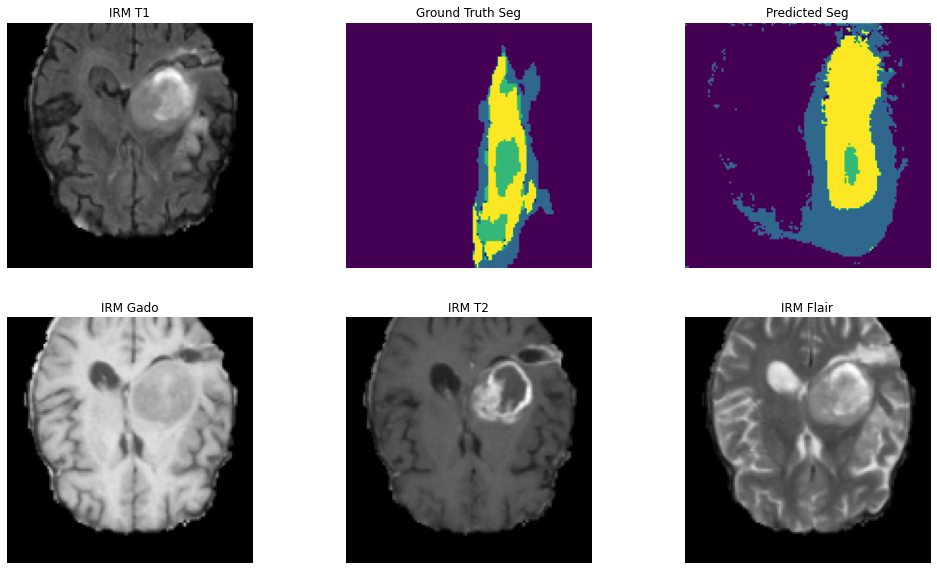

In [0]:
torch.cuda.empty_cache()
with torch.no_grad():
  model_0.eval()
  for i, sample in enumerate(train_loader, 1):
    (irm, mask, patient) = sample
    print(patient)
    break
  irm_ = to_var(irm.float(), device)
  mask_out_ = model_0(irm_)
  mask = to_numpy(mask)
  mask_out = to_numpy(mask_out_)
  plot_2D(irm[0], masks=mask[0], pred_masks=mask_out[0])

### 4.2) Ensemble method

Here we fuse the features at the last stage, after the four networks trained on each modality have predicted their output segmentation.

Note : this part has been run in the copy of this notebook because it took a long runtime and we needed to parallelize the code on several GPUs. The results are in the report.


In [0]:
models = [None]*4
train_losses = [[] for k in range(4)]
val_losses = [[] for k in range(4)]
print_frequency = 25

for k in range(4):
  mod = [k]
  training_set = Dataset_2D(mode="training", transform=flip_scale_crop_train, modalities=mod)
  train_loader = torch.utils.data.DataLoader(training_set, 
                                            batch_size=batch_size, shuffle=True,
                                            drop_last=True) 
  models[k] = Unet2D(1, 4, [32, 32, 64, 128, 256])
  models[k].cuda()
  optimizer = torch.optim.Adam(models[k].parameters(), lr=learning_rate)

  epochs = 1

  val_set = Dataset_2D(mode="validation", transform=flip_scale_crop_train, modalities=mod)
  val_loader = torch.utils.data.DataLoader(val_set, 
                                         batch_size=batch_size, shuffle=True,
                                         drop_last=True)

  for epoch in range(epochs+1):
      print('\nEpoch [{}/{}] '.format(epoch + 1, epochs))
      #print(session_name)

      models[k].train()
      print('[Training]')
      tr_loss = train_model(models[k], train_loader, mean_dice_loss_2, optimizer, fre=print_frequency)
      train_losses[k].append(tr_loss)

      if save_model and epoch % save_frequency == 0:
          save_checkpoint({'epoch': epoch,
                          'state_dict': models[k].state_dict(),
                          'optimizer': optimizer.state_dict()}, model_path)

      # validation for one epoch
      print('[Validation]')
      with torch.no_grad():
          models[k].eval()
          val_loss = validate_model(models[k], val_loader, criterion)
          val_losses[k].append(val_loss)

We encode this with simple voting, but one can also learn the weights of the ensemble. It requires a bit more coding though.

In [0]:
# Voting / ensemble prediction

def predict_ensemble(loader, models, batch_size=1):
    metrics = []
    for i, sample in tqdm(enumerate(loader, 1)):
        # Take variable and put them to GPU
        (irm, mask, patient) = sample
        irm = to_var(irm.float(), device)
        mask = to_numpy(mask)
        pred_mask = np.zeros_like(mask)
        for model_ in models:
          pred_mask_k = model_(irm)
          pred_mask_k = to_numpy(pred_mask)
          pred_mask += pred_mask_k
        
        ref = np.argmax(mask[0],axis=0)
        mask_out = np.argmax(pred_mask[0],axis=0)
        
        metric = evalAllmetric(ref, mask_out)
        metrics.append(metric)
        
    return metrics

### 4.3) Encoder features fusion

Here we code the intermediate option : each feature is encoded independently, then features are concatenated at the "bottom" of the U-net.

In [0]:
class HybridUnet(nn.Module):

  def __init__(self, n_channels, n_classes, encoder_channels, decoder_channels):
    super(HybridUnet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.encoder1 = Encoder(1, encoder_channels)
    self.encoder2 = Encoder(1, encoder_channels)
    self.encoder3 = Encoder(1, encoder_channels)
    self.encoder4 = Encoder(1, encoder_channels)
    out_channels = np.cumsum([1]+encoder_channels)[1:]
    self.decoder = Decoder([4 * a for a in out_channels], decoder_channels, n_classes)

  def forward(self, x):
    X1 = []
    X2 = []
    X3 = []
    X4 = []
    X5 = []
    x1, x2, x3, x4, x5 = self.encoder1(x[:, [0], ...])
    X1.append(x1)
    X2.append(x2)
    X3.append(x3)
    X4.append(x4)
    X5.append(x5)
    x1, x2, x3, x4, x5 = self.encoder2(x[:, [1], ...])
    X1.append(x1)
    X2.append(x2)
    X3.append(x3)
    X4.append(x4)
    X5.append(x5)
    x1, x2, x3, x4, x5 = self.encoder3(x[:, [2], ...])
    X1.append(x1)
    X2.append(x2)
    X3.append(x3)
    X4.append(x4)
    X5.append(x5)
    x1, x2, x3, x4, x5 = self.encoder4(x[:, [3], ...])
    X1.append(x1)
    X2.append(x2)
    X3.append(x3)
    X4.append(x4)
    X5.append(x5)
    y1 = torch.cat(X1, dim=1)
    y2 = torch.cat(X2, dim=1)
    y3 = torch.cat(X3, dim=1)
    y4 = torch.cat(X4, dim=1)
    y5 = torch.cat(X5, dim=1)
    return self.decoder(y1, y2, y3, y4, y5)

In [0]:
epochs = 3
batch_size = 64
print_frequency = 5

train_loader = torch.utils.data.DataLoader(training_2, 
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(validation_2, 
                                         batch_size=batch_size, shuffle=True,
                                         drop_last=True)

# train model
model_H = HybridUnet(4, 4, [12, 16, 32, 64, 128], [256, 128, 64, 64])
model_H.cuda()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#if torch.cuda.is_available():
#    model.cuda()
criterion = mean_dice_loss_2
optimizer = torch.optim.Adam(model_H.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
#early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(epochs+1):
    print('\nEpoch [{}/{}] '.format(epoch + 1, epochs))
    #print(session_name)

    model_H.train()
    print('[Training]')
    tr_loss = train_model(model_H, train_loader, mean_dice_loss_2, optimizer, fre=print_frequency)
    train_losses.append(tr_loss)

    if save_model and epoch % save_frequency == 0:
        save_checkpoint({'epoch': epoch,
                         'state_dict': model_H.state_dict(),
                         'optimizer': optimizer.state_dict()}, model_path)

    # validation for one epoch
    print('[Validation]')
    with torch.no_grad():
        model_H.eval()
        val_loss = validate_model(model_H, val_loader, criterion)
        val_losses.append(val_loss)        


Epoch [1/3] 
[Training]
[Train] Epoch: [1][5/45]	Dice Loss 0.8249 (Average 0.9022) 	Batch Time 37.6056 (Average 38.1611) 	
[Train] Epoch: [1][10/45]	Dice Loss 0.8199 (Average 0.8697) 	Batch Time 37.0797 (Average 37.6365) 	
[Train] Epoch: [1][15/45]	Dice Loss 0.7931 (Average 0.8400) 	Batch Time 36.9945 (Average 37.3845) 	
[Train] Epoch: [1][20/45]	Dice Loss 0.7820 (Average 0.8155) 	Batch Time 36.9282 (Average 37.2482) 	
[Train] Epoch: [1][25/45]	Dice Loss 0.6791 (Average 0.7891) 	Batch Time 36.4734 (Average 37.0633) 	
[Train] Epoch: [1][30/45]	Dice Loss 0.6427 (Average 0.7696) 	Batch Time 35.7446 (Average 36.9521) 	
[Train] Epoch: [1][35/45]	Dice Loss 0.6142 (Average 0.7529) 	Batch Time 36.4256 (Average 36.8598) 	
[Train] Epoch: [1][40/45]	Dice Loss 0.6575 (Average 0.7402) 	Batch Time 36.0888 (Average 36.7716) 	
[Train] Epoch: [1][45/45]	Dice Loss 0.6347 (Average 0.7301) 	Batch Time 36.0083 (Average 36.7149) 	
[Validation]
[Validation] Epoch: [1][18/18]	Dice Loss 0.7181 (Average 0.7294

In [0]:
test = Dataset_2D(mode="test", transform=flip_scale_crop_test, t=0.05, r=0.)
test_loader = torch.utils.data.DataLoader(test, 
                                          batch_size=batch_size,
                                          drop_last=True)

torch.cuda.empty_cache()
with torch.no_grad():
    model_H.eval()
    metrics = predict(test_loader, model_H, batch_size=64)

metrics_ar = np.stack(metrics,axis=0)
metrics_m = np.mean(metrics_ar,axis=0)
metrics_std = np.std(metrics_ar,axis=0)

mm = pd.DataFrame(metrics_m.reshape(3,-1),index=['wt','tc','et'])
mm.columns = ['Dice', 'Sensitivity', 'Specificity']
mm  

45it [25:30, 34.00s/it]


,Dice,Sensitivity,Specificity
wt,0.355960,0.229313,0.997203
tc,0.310267,0.194382,0.996922
et,0.235184,0.209082,0.995958


Quite good performances compared to the basic input-level fusion.

[('BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz', 'BRATS_152.nii.gz'

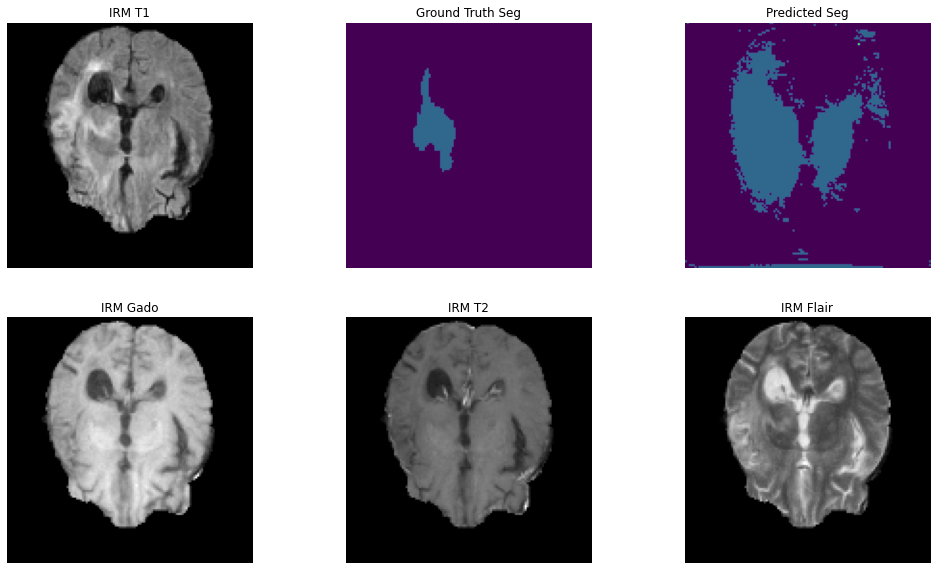

In [0]:
torch.cuda.empty_cache()
with torch.no_grad():
  model_H.eval()
  for i, sample in enumerate(test_loader, 1):
    (irm, mask, patient) = sample
    print(patient)
    break
  irm_ = to_var(irm.float(), device)
  mask_out_ = model_H(irm_)
  mask = to_numpy(mask)
  mask_out = to_numpy(mask_out_)
  plot_2D(irm[0], masks=mask[0], pred_masks=mask_out[0])